In [8]:
import numpy as np
import cupy as cp
from scipy.special import zeta, factorial, bernoulli
import scipy.integrate as integrate
from scipy.stats import norm
from scipy.misc import derivative
import pandas as pd

B_1 = -zeta(0.5)/np.sqrt(2 * np.pi)

def simMeanMaxGBM(drift, sigma, T, N, m):
    delta_t = T / m
    sims = cp.zeros((N, m+1), dtype="float32")
    sims[:, 1:] = cp.random.normal(drift * delta_t, sigma * delta_t**0.5, (N,m)) # note scale param is sd not var
    sims = cp.cumsum(sims, axis=1)
    sims = cp.max(sims, axis=1) # Note all these variables are called sims to be memory efficient
    return cp.mean(cp.exp(sims)), cp.exp(sims)

def exactMeanMaxGBM(r_, sigma, T):
    return (1 + sigma**2 / (2*r_)) * np.exp(r_*T) * norm.cdf((r_ + 0.5 * sigma**2)*T/(sigma * T**0.5)) + \
        norm.cdf(- (r_ - 0.5 * sigma**2) * T / (sigma*T**0.5)) * (1 - sigma**2 / (2 * r_))

# Here we will numerically integrate my own idea, with the correction added later

def toIntegrate(x, r_, sigma, T, m):
    drift = r_ - 1/2 * sigma**2
    def pdf(x):
        sqrtSigmaT = sigma * T**0.5
        return 1/sqrtSigmaT * norm.pdf((x - drift*T)/sqrtSigmaT) - 2 * drift / sigma**2 * np.exp(2 * drift*x / sigma**2) * norm.cdf((-x - drift * T)/sqrtSigmaT) +\
            np.exp(2 * drift * x / sigma**2) * norm.pdf((-x - drift * T)/sqrtSigmaT)/sqrtSigmaT
    def otherPdf(x):
        return 2 / (sigma * np.sqrt(2 * np.pi * T)) * np.exp(-1/(2 * sigma**2 * T) * (x-drift*T)**2) -\
            2 * drift/ sigma**2 * np.exp(2 * drift * x/ sigma**2)*norm.cdf((-x-drift*T)/(sigma * T**0.5))
    return pdf(np.log(x) + B_1 * sigma * np.sqrt(T/m) - np.log(S_0)) # Note the x values of the mean cancel

def simProbMax0(r_, sigma, T, N, m):
    drift = r_ - 1/2 * sigma**2
    delta_t = T / m
    sims = cp.zeros((N, m+1), dtype="float32")
    sims[:, 1:] = cp.random.normal(drift * delta_t, sigma * delta_t**0.5, (N,m)) # note scale param is sd not var
    paths = cp.cumsum(sims, axis=1)
    res = cp.any(paths > 0, axis=1)
    return (cp.sum(~res) / N).get()

# Solution of the probability using the theory of Johans paper thm 2.1
def exactProbMax0InfTime(r_, sigma, T, m):
    drift = r_ - 1/2 * sigma**2
    if drift >= 0:
        raise Exception("drift is larger or equal to 0, not allowed")
    B = - (drift / sigma) * np.sqrt(T/m) # this is beta
    r_values = np.arange(0, 150)
    zeta_vals = zeta(0.5 - r_values)
    summation = np.sum(zeta_vals/(factorial(r_values)*(2*r_values+1))* (-1)**r_values * (B**2 /2)**r_values)
    return np.exp(B / np.sqrt(2 * np.pi) * summation) * np.sqrt(2) * B

def own_first_order_approx_MC(S_0, r_, sigma, T, N, m):
    result = integrate.quad(toIntegrate, S_0, np.inf, args=(r_, sigma, T, m))[0]
    return np.exp(-r_ * T) * (result + S_0 * simProbMax0(r_, sigma, T, N, m)) - S_0

def own_first_order_approx_inf_horizon(S_0, r_, sigma, T, m):
    result = integrate.quad(toIntegrate, S_0, np.inf, args=(r_, sigma, T, m))[0]
    return np.exp(-r_ * T) * (result + S_0 * exactProbMax0InfTime(r_, sigma, T, m)) - S_0

def exact_price_cont_time(S_0, r_, sigma, T): # Checked with broadie paper
    return np.exp(-r_*T) * exactMeanMaxGBM(r_, sigma, T) * S_0 - S_0

# print(exact_price_cont_time(100, 0.1, 0.3, 0.5)) # sanity check with Broadie

def broadie_first_order_approx(S_0, r_, sigma, T, m): # checked with broadie
    v = exact_price_cont_time(S_0, r_, sigma, T)
    return (v + S_0) * np.exp(-B_1 * sigma * (T/m)**0.5) - S_0

# print(broadie_first_order_approx(100, 0.1, 0.3, 0.5, 5)) # Sanity check with broadie

def g(t, mu, T, sigma):
    return mu * T**0.5 / sigma * norm.cdf(mu * (T*t)**0.5/sigma) + \
           1 / np.sqrt(2 * np.pi * t) * np.exp(- mu**2 * T * t/(2 * sigma**2))

def broadie_second_order_approx(S_0, r_, sigma, T, m):
    v = exact_price_cont_time(S_0, r_, sigma, T)
    mu = r_ - 0.5 * sigma**2
    B_2 = 0.425
    term = 1 - B_1 * sigma * T**0.5/m**0.5 + (2*g(1, mu, T, sigma) * sigma * T**0.5 - mu * T + 2 * B_2 * sigma**2 * T)/ (4*m)
    return (v + S_0) * term - S_0

def second_order_approx_extra_term(S_0, r_, sigma, T, m, two_terms = False):
    # include_order_m is up to what order of m^- that number should be included (> 2)
    v = exact_price_cont_time(S_0, r_, sigma, T)
    mu = r_ - 0.5 * sigma**2
    B_2 = 0.425
    term = 1 - B_1 * sigma * T**0.5/m**0.5 + (2*g(1, mu, T, sigma) * sigma * T**0.5 - mu * T + 2 * B_2 * sigma**2 * T)/ (4*m)
    # r = 0 # This is the r in the sum of my paper
    # term += sigma * T**0.5/(2 * np.pi * m)**0.5 * zeta(-0.5 - r) * (-0.5)**r / (factorial(r) * (2*r+1)*(2*r+2)) * (mu * T**0.5/(sigma * m**0.5))**(2*r + 2)
    term += zeta(-0.5) * T**1.5 * mu**2/(2*(2*np.pi)**0.5 * m**1.5 * sigma)
    if two_terms:
        k = 1
        term += bernoulli(2 * k)[2*k] / factorial(2 * k) * derivative(g, 1, 1e-8, 2*k-1, (mu, T, sigma), 2 * (2*k-1) + 1)/ m**(2*k) * sigma * T**0.5
    return (v + S_0) * term - S_0


# print(broadie_second_order_approx(100, 0.1, 0.3, 0.5, 5)) # Sanity check with broadie, note I use the representation of my paper but answers are equivalent
def sim_price_lookback_put(S_0, r_, sigma, T, N, m, batch_size=100000000):
    # Important second argument is a CUPY array!
    drift = r_ - 0.5 * sigma ** 2
    sims_done = 0
    max_gbws = cp.zeros(N, dtype="float32")
    while sims_done < N:
        N_step = cp.min(np.array([batch_size//m, N - sims_done])).item()
        mean_GBM, max_gbws[sims_done:(sims_done + N_step)] = simMeanMaxGBM(drift, sigma, T, N_step, m)
        sims_done += N_step
    return cp.exp(-r_ * T) * cp.mean(max_gbws, dtype="float64") * S_0 - S_0, max_gbws

0.9482061918756637


In [ ]:
# simulating standard plot
mean, max_gbw = sim_price_lookback_put(100, 0.1, 0.3, 0.5, 10000000, 7)
print(mean, np.mean(max_gbw), np.exp(-0.1*0.5) * 100 * np.std(max_gbw) / np.sqrt(10000000))

x_points = np.arange(1, 101)
sims = np.zeros((x_points.size, 4))
r_ = 0.1
sigma = 0.3
T = 0.5
# from timeit import default_timer as timer # Time simulations
# start = timer()
# sim_price_lookback_put(100, r_, sigma, T, 100000000, 100)
# end = timer()
# print("Time", end - start) # Time in seconds, e.g. 5.38091952400282
# for i in range(0, x_points.size):
#     m = i+1
#     sims[i,:] = np.array([exact_price_cont_time(100, r_, sigma, T), broadie_first_order_approx(100, r_, sigma, T, m)
#         , broadie_second_order_approx(100, r_, sigma, T, m), sim_price_lookback_put(100, r_, sigma, T, 10000000, m)[0]])

In [144]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
sims = cp.asnumpy(sims)
x_points = cp.asnumpy(x_points)
plt.plot(x_points, sims[:, 0], label="Continuous time")
plt.plot(x_points, sims[:, 1], label="First order approximation")
plt.plot(x_points, sims[:, 2], label="Second order approximation")
plt.plot(x_points, sims[:, 3], label="Monte Carlo simulation")

plt.xlabel("m")
plt.ylabel("Price")
plt.title("Prices of different approximations")
plt.legend()
plt.grid()
plt.show()
plt.savefig('histogram.pgf')

print(sims[79])

<ipython-input-144-d465f421f736>:22: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


ValueError: Error processing '\(\displaystyle {−20}\)'
LaTeX Output:

! Package inputenc Error: Unicode character − (U+2212)
(inputenc)                not set up for use with LaTeX.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
<*> ...0000}\selectfont \(\displaystyle {−20}\)}
                                                  
!  ==> Fatal error occurred, no output PDF file produced!
Transcript written on texput.log.


In [41]:
# Table of every 20 points, note first point is m = 1
print(sims[39])
m_points = cp.array(range(19,100,20))
m_points = cp.asnumpy(m_points)
print(sims[m_points, 1:])
df = pd.DataFrame(np.round(sims[m_points, 1:], 5), index=m_points+1, columns=["First order", "Second order"
                                                                ,"Monte Carlo"])
df = df.rename_axis("m")
df.columns.name = df.index.name
df.index.name = None  # Makes m align with the column names
print(df)

df.to_latex('differentPricesTable.tex')

[15.35255547 13.12034315 13.24908913 13.23602936]
[[12.20843054 12.46603994 12.44172872]
 [13.12034315 13.24908913 13.23602936]
 [13.52670075 13.61251401 13.60421283]
 [13.76963219 13.83398434 13.83513119]
 [13.93571506 13.98719253 13.98795415]]
m   First order Second order Monte-carlo
20     12.20843     12.46604    12.44173
40     13.12034     13.24909    13.23603
60      13.5267     13.61251    13.60421
80     13.76963     13.83398    13.83513
100    13.93572     13.98719    13.98795


In [67]:
# Create the plots for first order approximations here

r_ = -0.005
sigma = 0.3
T = 0.5
S_0 = 100
x_points = cp.arange(1, 101)
sims = cp.zeros((x_points.size, 4))
for i in range(0, x_points.size):
    m = i+1
    sims[i,:] = cp.array([own_first_order_approx_inf_horizon(S_0, r_, sigma, T, m), own_first_order_approx_MC(S_0, r_, sigma, T, 10000000, m)
        , broadie_first_order_approx(S_0, r_, sigma, T, m), sim_price_lookback_put(S_0, r_, sigma, T, 10000000, m)[0]], dtype="float32")
sims = cp.asnumpy(sims)
x_points = cp.asnumpy(x_points)
np.save("firstOrderApproximations", sims)
np.save("x_pointsfirstOrderApproximations", x_points)

OutOfMemoryError: Out of memory allocating 3,680,000,000 bytes (allocated so far: 5,484,000,256 bytes).

<ipython-input-80-88207cb16cbe>:24: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Continuous time price: 18.230578058388076


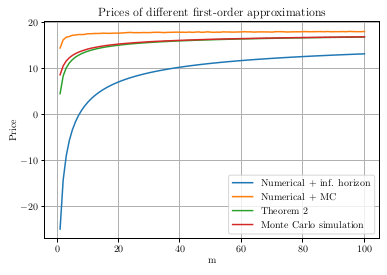

In [80]:
# Load data and make plot

sims = np.load("firstOrderApproximations.npy")
x_points = np.load("x_pointsfirstOrderApproximations.npy")
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'axes.unicode_minus': False
})
plt.plot(x_points, sims[:, 0], label="Numerical + inf. horizon")
plt.plot(x_points, sims[:, 1], label="Numerical + MC")
plt.plot(x_points, sims[:, 2], label="Theorem 2")
plt.plot(x_points, sims[:, 3], label="Monte Carlo simulation")

plt.xlabel("m")
plt.ylabel("Price")
plt.title("Prices of different first-order approximations")
plt.legend()
plt.grid()

plt.show()
plt.savefig('firstOrderApproximationsCase1.pgf')
print(f"Continuous time price: {exact_price_cont_time(S_0, -0.005, 0.3, 0.5)}")
# Two reality checks
# print(integrate.quad(lambda x: toIntegrate(x*np.exp(-B_1*sigma*np.sqrt(T/m)), r_, sigma, T, m)/x, S_0, np.inf)[0]) # should be one
# res = integrate.quad(lambda x: toIntegrate(x*np.exp(-B_1*sigma*np.sqrt(T/m)), r_, sigma, T, m), S_0, np.inf)[0]
# print(np.exp(-r_ * T) *res - S_0, exact_price_cont_time(S_0, r_, sigma, T)) # Should be equal

In [ ]:
# first order approximations with different parameters

r_ = -0.1
sigma = 0.5
T = 5
S_0 = 100
x_points = cp.arange(1, 101)
sims = cp.zeros((x_points.size, 4))
for i in range(0, x_points.size):
    m = i+1
    sims[i,:] = cp.array([own_first_order_approx_inf_horizon(S_0, r_, sigma, T, m), own_first_order_approx_MC(S_0, r_, sigma, T, 10000000, m)
        , broadie_first_order_approx(S_0, r_, sigma, T, m), sim_price_lookback_put(S_0, r_, sigma, T, 10000000, m)[0]], dtype="float32")
sims = cp.asnumpy(sims)
x_points = cp.asnumpy(x_points)
np.save("firstOrderApproximationsPic2", sims)
np.save("x_pointsfirstOrderApproximationsPic2", x_points)

<ipython-input-75-52d07aebf04c>:23: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Continuous time price: 199.0519394035265


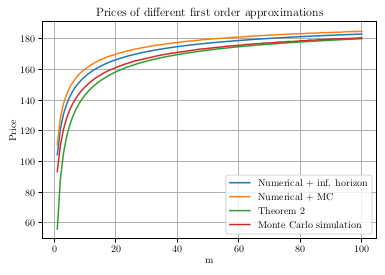

In [75]:
sims = np.load("firstOrderApproximationsPic2.npy")
x_points = np.load("x_pointsfirstOrderApproximationsPic2.npy")
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
plt.plot(x_points, sims[:, 0], label="Numerical + inf. horizon")
plt.plot(x_points, sims[:, 1], label="Numerical + MC")
plt.plot(x_points, sims[:, 2], label="Theorem 2")
plt.plot(x_points, sims[:, 3], label="Monte Carlo simulation")

plt.xlabel("m")
plt.ylabel("Price")
plt.title("Prices of different first order approximations")
plt.legend()
plt.grid()

plt.show()
plt.savefig('firstOrderApproximationsCase2.pgf')
print(f"Continuous time price: {exact_price_cont_time(S_0, -0.1, 0.5, 5)}")

In [36]:
#################
# Plots of relative error compared to continuous price for different parameters
r_ = 0.05
sigma = 0.3
T = 0.5
S_0 = 100
# First the plot with r deviating
r_points = np.array([-0.5, -0.2,-0.05,0.002, 0.05, 0.1, 0.20])
sigma_points = np.array([0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1])
T_points = np.array([0.1, 0.25, 0.5, 1, 2, 5, 10])
x_points = np.arange(10, 101, 2)
sims = cp.zeros((x_points.size, r_points.size, 3))
for i,  m in enumerate(x_points):
    for idx in range(r_points.size): # TODO REDO THIS CHART N = 10m instead of 1m
        disc_price = sim_price_lookback_put(S_0, r_points[idx], sigma, T, 10000000, m)[0]
        #disc_price = broadie_second_order_approx(S_0, r_points[idx], sigma, T, m)
        cont_price = exact_price_cont_time(S_0, r_points[idx], sigma, T)
        sims[i,idx, 0] = (cont_price - disc_price)/disc_price
    for idx in range(sigma_points.size): # TODO REDO THIS CHART N = 10m instead of 1m
        disc_price = sim_price_lookback_put(S_0, r_, sigma_points[idx], T, 10000000, m)[0]
        #disc_price = broadie_second_order_approx(S_0, r_, sigma_points[idx], T, m)
        cont_price = exact_price_cont_time(S_0, r_, sigma_points[idx], T)
        sims[i,idx, 1] = (cont_price - disc_price)/disc_price
    for idx in range(T_points.size): # TODO REDO THIS CHART N = 10m instead of 1m
        disc_price = sim_price_lookback_put(S_0, r_ , sigma, T_points[idx], 10000000, m)[0]
        #disc_price = broadie_second_order_approx(S_0, r_, sigma, T_points[idx], m)
        cont_price = exact_price_cont_time(S_0, r_, sigma, T_points[idx])
        sims[i,idx, 2] = (cont_price - disc_price)/disc_price
sims = cp.asnumpy(sims)
# np.save("relativeErrorr_deviations", sims)
# np.save("x_pointsRelativeErrorr_deviations", x_points)

<ipython-input-22-50c7c840fa50>:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(3, 1, 1)
<ipython-input-22-50c7c840fa50>:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(3, 1, 1)
<ipython-input-22-50c7c840fa50>:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

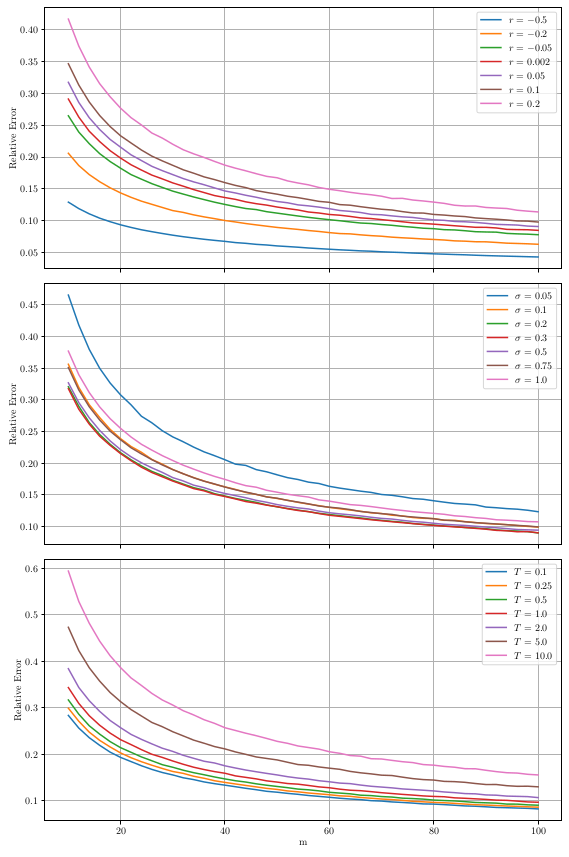

In [22]:
r_points = np.array([-0.5, -0.2,-0.05,0.002, 0.05, 0.1, 0.20])
sigma_points = np.array([0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1])
T_points = np.array([0.1, 0.25, 0.5, 1, 2, 5, 10])
# A plot differing r_
sims = np.load("relativeErrorr_deviations.npy")
x_points = np.load("x_pointsRelativeErrorr_deviations.npy")
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
fig = plt.figure(figsize=(8,12))
# ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)
# ax2 = plt.subplot2grid((2,2), (1,0))
# ax3 = plt.subplot2grid((2,2), (1,1))
# for idx, r_ in enumerate(r_points):
#     ax1.plot(x_points, sims[:, idx, 0], label=f"$r={r_}$")
# for idx, sigma in enumerate(sigma_points):
#     ax2.plot(x_points, sims[:, idx, 1], label=f"$\\sigma={sigma}$")
# for idx, T in enumerate(T_points):
#     ax3.plot(x_points, sims[:, idx, 2], label=f"$T={T}$")
# for ax in fig.get_axes():
#     ax.legend()
#     ax.grid()
#     ax.set(xlabel='m', ylabel='Relative Error')
# fig.tight_layout()
# fig.savefig("relativeError_deviationContinous.pgf")
# 3 beneath each other
for idx, r_ in enumerate(r_points):
    ax = fig.add_subplot(3, 1, 1)
    ax.plot(x_points, sims[:, idx, 0], label=f"$r={r_}$")
for idx, sigma in enumerate(sigma_points):
    ax = fig.add_subplot(3, 1, 2)
    ax.plot(x_points, sims[:, idx, 1], label=f"$\\sigma={sigma}$")
for idx, T in enumerate(T_points):
    ax = fig.add_subplot(3, 1, 3)
    ax.plot(x_points, sims[:, idx, 2], label=f"$T={T}$")
for ax in fig.get_axes():
    ax.legend()
    ax.grid()
    ax.set(xlabel='m', ylabel='Relative Error')
    ax.label_outer() # Only label outer graphs
fig.tight_layout()
fig.savefig("relativeError_deviationContinous.pgf")

In [29]:
###################
# These are plots about the relative error of the second-order approximation vs the "true price"
r_ = 0.05
sigma = 0.3
T = 0.5
S_0 = 100
# First the plot with r deviating
r_points = np.array([-0.5, -0.2,-0.05,0.002, 0.05, 0.1, 0.20])
sigma_points = np.array([0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1])
T_points = np.array([0.1, 0.25, 0.5, 1, 2, 5, 10])
x_points = np.arange(10, 51, 4)
sims = cp.zeros((x_points.size, r_points.size, 3))
for i,  m in enumerate(x_points):
    for idx in range(r_points.size):
        disc_price_true = sim_price_lookback_put(S_0, r_points[idx], sigma, T, 40000000, m)[0]
        disc_price_approx = broadie_second_order_approx(S_0, r_points[idx], sigma, T, m)
        sims[i,idx, 0] = (disc_price_approx - disc_price_true)/disc_price_true
    for idx in range(sigma_points.size):
        disc_price_true = sim_price_lookback_put(S_0, r_, sigma_points[idx], T, 40000000, m)[0]
        disc_price_approx = broadie_second_order_approx(S_0, r_, sigma_points[idx], T, m)
        sims[i,idx, 1] = (disc_price_approx - disc_price_true)/disc_price_true
    for idx in range(T_points.size):
        disc_price_true = sim_price_lookback_put(S_0, r_, sigma, T_points[idx], 40000000, m)[0]
        disc_price_approx = broadie_second_order_approx(S_0, r_, sigma, T_points[idx], m)
        sims[i,idx, 2] = (disc_price_approx - disc_price_true)/disc_price_true
np.save("x_pointsRelativeError_SecondOrder", x_points)
np.save("relativeError_SecondOrder", sims)

In [2]:
# Generate the random parameter plot
r_draws = np.random.uniform(-0.05, 0.25, 1000)
sigma_draws = np.random.uniform(0.05, 0.5, 1000)
T_draws = np.random.uniform(0.1, 5, 1000)
m = 25
S_0 = 100
sims_random = cp.zeros(r_draws.size)
for i in range(r_draws.size):
    disc_price_true = sim_price_lookback_put(S_0, r_draws[i], sigma_draws[i], T_draws[i], 40000000, m)[0]
    disc_price_approx = broadie_second_order_approx(S_0, r_draws[i], sigma_draws[i], T_draws[i], m)
    sims_random[i] = (disc_price_approx - disc_price_true)/disc_price_true
sims_random = cp.asnumpy(sims_random)
# np.save("relativeError_SecondOrderRandomParamsv2", sims_random)

KeyboardInterrupt: 

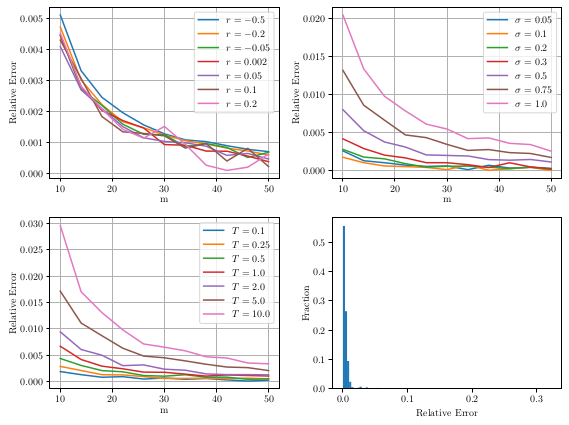

In [22]:
# A plot differing r_
sims = np.load("relativeError_SecondOrder.npy")
x_points = np.load("x_pointsRelativeError_SecondOrder.npy")
sims_random = np.load("relativeError_SecondOrderRandomParamsv2.npy")
sims = np.abs(sims)
sims_random = np.abs(sims_random)
r_points = np.array([-0.5, -0.2,-0.05,0.002, 0.05, 0.1, 0.20])
sigma_points = np.array([0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1])
T_points = np.array([0.1, 0.25, 0.5, 1, 2, 5, 10])
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (0,1))
ax3 = plt.subplot2grid((2,2), (1,0))
ax4 = plt.subplot2grid((2,2), (1,1))
for idx, r_ in enumerate(r_points):
    ax1.plot(x_points, sims[:, idx, 0], label=f"$r={r_}$")
for idx, sigma in enumerate(sigma_points):
    ax2.plot(x_points, sims[:, idx, 1], label=f"$\\sigma={sigma}$")
for idx, T in enumerate(T_points):
    ax3.plot(x_points, sims[:, idx, 2], label=f"$T={T}$")
sims_random = sims_random[np.argsort(sims_random)][:990]
weights = np.ones_like(sims_random[:]) / len(sims_random[:])
ax4.hist(sims_random[:], weights=weights, bins=100)
ax4.set(xlabel='Relative Error', ylabel='Fraction')
for ax in fig.get_axes()[0:3]:
    ax.legend()
    ax.grid()
    ax.set(xlabel='m', ylabel='Relative Error')
fig.tight_layout()
fig.savefig("relativeError_SecondOrderPictures.pgf")

In [ ]:
# This looks at convergence speed for large m.
r_ = 0.05
sigma = 0.3
T = 0.5
S_0 = 100
x_points = np.logspace(0, 10, 1000, dtype="uint")
sims = np.zeros(x_points.size)
for i,  m in enumerate(x_points):
    #disc_price = sim_price_lookback_put(S_0, r_, sigma, T, 1000000, m)[0]
    disc_price = broadie_second_order_approx(S_0, r_, sigma, T, m)
    cont_price = exact_price_cont_time(S_0, r_, sigma, T)
    sims[i] = (cont_price - disc_price)/disc_price
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
fig, ax = plt.subplots()
plt.plot(x_points, sims, label="RE")
ax.loglog()
plt.xlabel("m")
plt.ylabel("Relative Error")
plt.title("Error of continuous price compared to discrete price")
plt.legend()
plt.grid()
plt.yscale("log")
plt.xscale("log")
plt.savefig("convergenceRelativeErrorContinuous.pgf")

In [5]:
# Calculate the relative error distribution for different random parameters for large m
r_ = 0.05
sigma = 0.3
T = 0.5
N = 1000000 # Number of samples
r_draws = np.random.uniform(-0.05, 0.25, N)
sigma_draws = np.random.uniform(0.05, 0.5, N)
T_draws = np.random.uniform(0.1, 5, N)
S_0 = 100
x_points = np.array([10**2, 10**3, 10**4, 10**5, 10**6])
sims = np.zeros((N, x_points.size))
figureValues = np.zeros(x_points.size) # The values of the corresponding figure in the section
for i,  m in enumerate(x_points):
    disc_price = broadie_second_order_approx(S_0, r_draws, sigma_draws, T_draws, m)
    cont_price = exact_price_cont_time(S_0, r_draws, sigma_draws, T_draws)
    sims[:, i] = (cont_price - disc_price)/disc_price
    disc_price_fig = broadie_second_order_approx(S_0, r_, sigma, T, m)
    cont_price_fig = exact_price_cont_time(S_0, r_, sigma, T)
    figureValues[i] = (cont_price_fig - disc_price_fig)/disc_price_fig
print(np.mean(sims[:,1]))

0.050136380340254784


In [6]:
# generate the plots and table
import pandas as pd
m_points = x_points
data = np.array([np.mean(sims, axis=0),np.std(sims, axis=0),np.median(sims, axis=0)]).T
data = np.c_[figureValues, data]
df = pd.DataFrame(np.round(data, 5), index=m_points, columns=["placeholder","Mean", "Std", "Median"])
df = df.rename_axis("m")
df.columns.name = df.index.name
df.index.name = None  # Makes m align with the column names
df.to_latex("randomParametersRelativeErrorContPriceLargem.tex",
            escape=False, header=[r"Figure \ref{fig:RelativeErrorContPriceVeryLargem}","Mean", "Std", "Median"])
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    "axes.unicode_minus": False
})
fig, ax = plt.subplots()
weights = np.ones_like(sims[:,3]) / len(sims[:,3])
ax.hist(sims[:,3], weights=weights, bins=100)
ax.set_title("Histogram of relative error")
ax.set_xlabel("Relative Error")
fig.savefig("distributionRandomParametersLargem.pgf")

In [3]:
# Generate same plot as introduction but with a confidence interval and also a table
r_ = 0.1
sigma = 0.3
T = 0.5
S_0 = 100
N = 10000000

In [ ]:
x_points = np.arange(1, 101)
sims = cp.zeros((x_points.size, 4))
for i, m in enumerate(x_points):
    sims[i,0], max_gbws = sim_price_lookback_put(S_0, r_, sigma, T, N, m)
    sims[i,1] = cp.std(cp.exp(-r_ * T) * max_gbws * S_0 - S_0)
    sims[i,2], max_gbws = sim_price_lookback_put(S_0, r_, sigma, T, N//100, m)
    sims[i,3] = cp.std(cp.exp(-r_ * T) * max_gbws * S_0 - S_0)

sims = cp.asnumpy(sims)
np.save("monteCarloWithConfidenceInterval", sims)
np.save("m_pointsMonteCarloWithConfidenceInterval", x_points)

In [30]:
import matplotlib.pyplot as plt
import matplotlib
sims = np.load("monteCarloWithConfidenceInterval.npy")
m_points = np.load("m_pointsMonteCarloWithConfidenceInterval.npy")
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
fig, ax = plt.subplots()
ax.plot(m_points[50:],sims[50:,0], label="N=10m")
ci = sims[50:,1]/np.sqrt(N)
ax.fill_between(m_points[50:], (sims[50:,0]-1.96*ci), (sims[50:,0]+1.96*ci), color='b', alpha=.2)
ax.plot(m_points[50:],sims[50:,2],label="N=100000")
ci = sims[50:,3]/np.sqrt(N/100)
ax.fill_between(m_points[50:], (sims[50:,2]-1.96*ci), (sims[50:,2]+1.96*ci), color='r', alpha=.1)
plt.grid()
ax.set_xlabel("m")
ax.set_ylabel("Price")
ax.legend(loc="upper left")
ax.set_title("Monte Carlo estimations with 95% confidence interval")
plt.savefig("MonteCarloEstWith95CI.pgf")
# Create the table
sims = sims[:, [0,1]]
sims[:,1] = sims[:,1]/np.sqrt(N)
sims = np.c_[sims, sims[:,0] - 1.96 * sims[:,1],sims[:,0] + 1.96 * sims[:,1]]
sims = sims[19::20]
df = pd.DataFrame(np.round(sims, 5), index=m_points[19::20], columns=["Mean", "S.E.", "95% lower limit", "95% higher limit"])
df = df.rename_axis("m")
df.columns.name = df.index.name
df.index.name = None  # Makes m align with the column names
df.to_latex("TableMonteCarloWithCI.tex")

In [13]:
# table time idea
from cupyx.time import repeat
S_0 = 100
r_ = 0.1
sigma = 0.3
T = 0.5
N_std = 10000000 # Number of paths to estimate std of price
m_points = np.array([5, 10, 20, 40, 80, 160])
sims = cp.zeros((m_points.size, 6)) # Left to right: true price, 2nd order, std, absolute error, N_equivalent, time to calc
sims[:,0] = cp.array([10.06425,11.39775,12.44463,13.23942,13.82950,14.26104])
for i, m in enumerate(m_points):
    sims[i, 1] = broadie_second_order_approx(S_0, r_, sigma, T, m)
    max_gbws = sim_price_lookback_put(S_0, r_, sigma, T, N_std, m)[1]
    sims[i, 2] = cp.std(cp.exp(-r_ * T) * max_gbws * S_0 - S_0, dtype="float64")
    # Measuring time to calculate the price
    sims[i, 3] = np.abs(sims[i, 1] - sims[i, 0])
    sims[i, 4] = int((1.96 * sims[i ,2]/sims[i, 3])**2)
    times = repeat(sim_price_lookback_put,(S_0, r_, sigma, T, int(sims[i, 4]), m),n_repeat=5)
    print(times)
    sims[i, 5] = np.mean(times.gpu_times)
np.save("simulationsTimeTableData", cp.asnumpy(sims))

sim_price_lookback_put:    CPU:  849.120 us   +/-198.157 (min:  636.200 / max: 1197.100) us     GPU-0: 3061.984 us   +/-187.826 (min: 2879.744 / max: 3417.408) us
sim_price_lookback_put:    CPU:  787.200 us   +/-154.199 (min:  632.500 / max:  987.100) us     GPU-0:17706.131 us   +/-142.589 (min:17530.464 / max:17903.233) us
sim_price_lookback_put:    CPU:  902.560 us   +/-89.867 (min:  784.700 / max: 1013.500) us     GPU-0:122667.531 us   +/-666.262 (min:121943.680 / max:123709.564) us
sim_price_lookback_put:    CPU: 2039.080 us   +/-343.593 (min: 1831.900 / max: 2724.500) us     GPU-0:852000.769 us   +/-490.560 (min:851503.540 / max:852718.506) us
sim_price_lookback_put:    CPU:11189.400 us   +/-1355.713 (min: 9742.100 / max:13159.600) us     GPU-0:6047857.031 us   +/-1618.554 (min:6045727.539 / max:6050486.328) us
sim_price_lookback_put:    CPU:89261.780 us   +/-3422.610 (min:86872.800 / max:96002.800) us     GPU-0:43825682.031 us   +/-5597.039 (min:43819839.844 / max:43834082.031) u

In [8]:
from cupyx.time import repeat # Time tables moeten opnieuw
print(repeat(sim_price_lookback_put, (100, 0.1, 0.4, 1, 10000000, 100), n_repeat=5))

sim_price_lookback_put:    CPU: 2714.700 us   +/-223.548 (min: 2516.100 / max: 3107.200) us     GPU-0:1295601.782 us   +/-466.038 (min:1295031.006 / max:1296356.689) us


In [4]:
import pandas as pd
# Create the table
sims = np.load("simulationsTimeTableData.npy")
data = sims[:, [0, 1, 3, 4, 5]]
m_points = np.array([5, 10, 20, 40, 80, 160])
df = pd.DataFrame(np.round(data, 5), index=m_points, columns=["True price", "2nd-order", "Abs error", "N equivalent", "Seconds"])
df["N equivalent"] = pd.to_numeric(df["N equivalent"], downcast="integer")
df = df.rename_axis("m")
df.columns.name = df.index.name
df.index.name = None  # Makes m align with the column names
print(df)
df.to_latex("simulationsTimeTable.tex", escape=False, header=["True price", "2nd-order", "Abs error", r"$\tilde{N}$", "Seconds"])

m    True price  2nd-order  Abs error  N equivalent   Seconds
5      10.06425   10.18203    0.11778         69127   0.00306
10     11.39775   11.44688    0.04913        405224   0.01771
20     12.44463   12.46604    0.02141       2170863   0.12267
40     13.23942   13.24909    0.00967      10802373   0.85200
80     13.82950   13.83398    0.00448      50702151   6.04786
160    14.26104   14.26317    0.00213     227203989  43.82568


In [5]:
# Draw a graph with computation time as number of draws
computing_time = data[:, 3] * m_points
popt = np.polyfit(m_points, computing_time, 3)
polyEst = np.poly1d(popt)
xx = np.linspace(2, 200, 100)
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
fig, ax = plt.subplots()
ax.plot(m_points, computing_time, "o", label="Data")
ax.plot(xx, polyEst(xx), label="Polynomial Fit")
ax.grid()
r_squared = 1 - np.sum((polyEst(m_points)-computing_time)**2)/np.sum((computing_time - np.mean(computing_time))**2)
ax.text(0.04, 0.88, f"$R^2$ = {r_squared}", transform=plt.gca().transAxes)
plt.legend(loc="lower right")
ax.set_xlabel("m")
ax.set_ylabel(r"$\tilde{N}*m$")
ax.set_title("Simulations");
plt.savefig("SimulationTimePlotAsDraws.pgf")
print(polyEst)

           3             2
1.008e+04 x - 2.141e+05 x + 3.56e+06 x - 1.757e+07


In [7]:
# Draw a graph with computation time in seconds
computing_time = sims[:,5]
popt = np.polyfit(m_points, computing_time, 3)
polyEst = np.poly1d(popt)
xx = np.linspace(2, 350, 200)
fig, ax = plt.subplots()
ax.plot(m_points, computing_time, "o", label="Data")
ax.plot(xx, polyEst(xx), label="Polynomial Fit")
ax.grid()
r_squared = 1 - np.sum((polyEst(m_points)-computing_time)**2)/np.sum((computing_time - np.mean(computing_time))**2)
ax.text(0.04, 0.91, f"$R^2$ = {r_squared}", transform=plt.gca().transAxes)
plt.legend(loc="lower right")
ax.set_xlabel("m")
ax.set_ylabel("Seconds")
ax.set_title("Computation time");
plt.savefig("SimulationTimePlotAsSeconds.pgf")
print(polyEst)

2.6836846985858114


In [23]:
######################
from cupyx.time import repeat # Time of section 2.1
print(repeat(sim_price_lookback_put, (100, 0.1, 0.3, 0.5, 100000, 50), n_repeat=10))
print(repeat(sim_price_lookback_put, (100, 0.1, 0.3, 0.5, 10000000, 50), n_repeat=10))

sim_price_lookback_put:    CPU:  483.880 us   +/-56.082 (min:  382.500 / max:  538.700) us     GPU-0: 8981.075 us   +/-183.667 (min: 8795.168 / max: 9486.240) us
sim_price_lookback_put:    CPU: 1725.140 us   +/-472.848 (min: 1327.300 / max: 2854.600) us     GPU-0:847293.921 us   +/-397.675 (min:846482.117 / max:848054.993) us


In [47]:
# Benchmark CPU vs GPU
def simMeanMaxGBM(drift, sigma, T, N, m):
    delta_t = T / m
    sims = np.zeros((N, m+1), dtype="float32")
    sims[:, 1:] = np.random.normal(drift * delta_t, sigma * delta_t**0.5, (N,m)) # note scale param is sd not var
    sims = np.cumsum(sims, axis=1)
    sims = np.max(sims, axis=1) # Note all these variables are called sims to be memory efficient
    return np.mean(np.exp(sims)), np.exp(sims)

def sim_price_lookback_put(S_0, r_, sigma, T, N, m, batch_size=100000000):
    # Important second argument is a CUPY array!
    drift = r_ - 0.5 * sigma ** 2
    sims_done = 0
    max_gbws = np.zeros(N, dtype="float32")
    while sims_done < N:
        N_step = np.min(np.array([batch_size//m, N - sims_done])).item()
        mean_GBM, max_gbws[sims_done:(sims_done + N_step)] = simMeanMaxGBM(drift, sigma, T, N_step, m)
        sims_done += N_step
    return np.exp(-r_ * T) * np.mean(max_gbws, dtype="float64") * S_0 - S_0, max_gbws
print(repeat(sim_price_lookback_put, (100, 0.1, 0.4, 1, 10000000, 100), n_repeat=5))

NameError: name 'repeat' is not defined

In [119]:
# Here differences between the second-order approximation with extra terms are shown
S_0 = 100
r_ = 0.1
sigma = 0.3
T = 0.5
m_points = np.array([5, 10, 20, 40, 80, 160])
sims = np.zeros((m_points.size, 4)) # Left to right: true price, 2nd order, std, absolute error, N_equivalent, time to calc
sims[:,0] = np.array([10.06425,11.39775,12.44463,13.23942,13.82950,14.26104])
sims[:,1] = broadie_second_order_approx(S_0, r_, sigma, T, m_points)
sims[:,2] = second_order_approx_extra_term(S_0, r_, sigma, T, m_points)
sims[:,3] = second_order_approx_extra_term(S_0, r_, sigma, T, m_points, True)

# Create the three tables
table_names = ["second-order_error_table.tex", "second-order_error_one_extra_term.tex",
               "second-order_error_two_extra_terms.tex"]
for i in range(0, 3):
    data = sims[:, [0, i+1]]
    data = np.c_[data, np.abs(data[:,1] - data[:, 0]), np.abs((data[:,1] - data[:, 0]))/data[:, 0]]
    df = pd.DataFrame(np.round(data, 5), index=m_points, columns=["True price", "Approximation", "Abs error", "RE"])
    df = df.rename_axis("m")
    df.columns.name = df.index.name
    df.index.name = None  # Makes m align with the column names
    print(df)
    df.to_latex(table_names[i])


m    True price  Approximation  Abs error       RE
5      10.06425       10.18203    0.11778  0.01170
10     11.39775       11.44688    0.04913  0.00431
20     12.44463       12.46604    0.02141  0.00172
40     13.23942       13.24909    0.00967  0.00073
80     13.82950       13.83398    0.00448  0.00032
160    14.26104       14.26317    0.00213  0.00015
m    True price  Approximation  Abs error       RE
5      10.06425       10.18051    0.11626  0.01155
10     11.39775       11.44634    0.04859  0.00426
20     12.44463       12.46585    0.02122  0.00171
40     13.23942       13.24902    0.00960  0.00073
80     13.82950       13.83396    0.00446  0.00032
160    14.26104       14.26316    0.00212  0.00015
m    True price  Approximation  Abs error       RE
5      10.06425       10.16437    0.10012  0.00995
10     11.39775       11.44230    0.04455  0.00391
20     12.44463       12.46484    0.02021  0.00162
40     13.23942       13.24877    0.00935  0.00071
80     13.82950       13.83390 